In [ ]:
# Import  libraries
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text  # Registers the ops.
from keras.utils import to_categorical
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\anaconda3\envs\newenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\ProgramData\anaconda3\envs\newenv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [ ]:
# Read the training and test datasets from CSV files
df_train = pd.read_csv(r"C:\Users\Administrator\Downloads\archive (8)\train.csv")
df_test = pd.read_csv(r"C:\Users\Administrator\Downloads\archive (8)\test.csv")

In [ ]:
# Display the first few rows of the training dataset
df_train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
# Define a dictionary mapping numerical labels to text categories
TEXT_LABELS = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

In [ ]:
# Define a function to combine title and description into a single text column
def combine_title_and_description(df):
    # Returns a dataset with the title and description fields combined
    df['text'] = df[['Title', 'Description']].agg('. '.join, axis=1)
    df = df.drop(['Title', 'Description'], axis=1)
    return df

In [ ]:
# Apply the function to training and test datasets
df_train = combine_title_and_description(df_train)
df_test = combine_title_and_description(df_test)
df_train.head()

,Class Index,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [ ]:
df_test.head()

,Class Index,text
0,3,Fears for T N pension after talks. Unions repr...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP)....
3,4,Prediction Unit Helps Forecast Wildfires (AP)....
4,4,Calif. Aims to Limit Farm-Related Smog (AP). A...


In [ ]:
# Print the shape of the training and test datasets
print('Shape of the training data: ', df_train.shape)
print('Shape of the test data: ', df_test.shape)

Shape of the training data:  (120000, 2)
Shape of the test data:  (7600, 2)


In [ ]:
# Group by 'Class Index' and count entries to see data distribution per class
df_train.groupby('Class Index').count()

,text
Class Index,
1,30000
2,30000
3,30000
4,30000


In [ ]:
# Display the 'text' column of the training dataset
df_train['text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal. Red Sox gen...
119997    Saban not going to Dolphins yet. The Miami Dol...
119998    Today's NFL games. PITTSBURGH at NY GIANTS Tim...
119999    Nets get Carter from Raptors. INDIANAPOLIS -- ...
Name: text, Length: 120000, dtype: object

In [ ]:
#  setup and remove stopwords for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import multiprocessing as mp

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return " ".join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply the function to remove stopwords from the 'text' column in train dataset
df_train['clean_text'] = df_train['text'].apply(remove_stopwords)

In [ ]:
# Apply the function to remove stopwords from the 'text' column in test dataset
df_test['clean_text']=df_test['text'].apply(remove_stopwords)

In [ ]:
X_train = df_train['text']

# Initialize LabelEncoder and encode labels into one-hot vectors for classification
le = LabelEncoder()
y_train = df_train['Class Index']
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes=4)


X_test = df_test['text']
y_test = df_test['Class Index']
y_test = le.transform(y_test)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
# Define a text input layer for a TensorFlow model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# Define a preprocessor layer from TensorFlow Hub for BERT model
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
# Define a BERT encoder layer, set as trainable
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)
# Extract pooled and sequence outputs from BERT
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [ ]:
hub_inputs = preprocessor(['ID for each word, with zero padding at the end.'])
{key: value[0, :25].numpy() for key, value in hub_inputs.items()}

{'input_word_ids': array([  101,  8909,  2005,  2169,  2773,  1010,  2007,  5717, 11687,
         4667,  2012,  1996,  2203,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]),
 'input_mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 'input_type_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])}

In [ ]:
# Process the inputs through BERT to get outputs
result = encoder(
    inputs=hub_inputs,
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

Pooled output shape: (1, 768)
Sequence output shape: (1, 128, 768)


In [ ]:
# Configuration for model training
epochs = 3
batch_size = 32
eval_batch_size = 32
# Calculate the number of steps per epoch and warmup steps
train_data_size = df_train.shape[0]
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
# Initialize learning rate and setup optimizer with warmup phase
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# Function to build the TensorFlow model with BERT encoder
def build_model(num_classes, optimizer, max_len=512):
    # Define the input layer for text data
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
     # Add a preprocessing layer to handle text transformation for BERT
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
     # Add the BERT encoder layer from TensorFlow Hub
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    # Extract pooled output for classification tasks
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    out = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)

    # Create and compile the model
    model = tf.keras.models.Model(text_input, out)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Build and summarize the model
model = build_model(num_classes=4, optimizer=optimizer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
# Setup model training callbacks for saving the best model and early stopping
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
# Train the model
history = model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          epochs=epochs,
          callbacks=[checkpoint, early_stopping],
          batch_size=batch_size,
          validation_batch_size=eval_batch_size,
          verbose=1)

Epoch 1/3
3750/3750 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8999 
Epoch 1: val_accuracy improved from -inf to 0.94276, saving model to model.h5
3750/3750 [==============================] - 41663s 11s/step - loss: 0.2886 - accuracy: 0.8999 - val_loss: 0.1732 - val_accuracy: 0.9428
Epoch 2/3
3750/3750 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9570 
Epoch 2: val_accuracy improved from 0.94276 to 0.94895, saving model to model.h5
3750/3750 [==============================] - 43062s 11s/step - loss: 0.1355 - accuracy: 0.9570 - val_loss: 0.1624 - val_accuracy: 0.9489
Epoch 3/3
3750/3750 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9746 
Epoch 3: val_accuracy improved from 0.94895 to 0.94908, saving model to model.h5
3750/3750 [==============================] - 43624s 12s/step - loss: 0.0838 - accuracy: 0.9746 - val_loss: 0.2000 - val_accuracy: 0.9491


In [ ]:
# Ensure the model uses the best weights
model.load_weights('model.h5')

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes
y_true = np.argmax(y_test, axis=1)


238/238 [==============================] - 1000s 4s/step


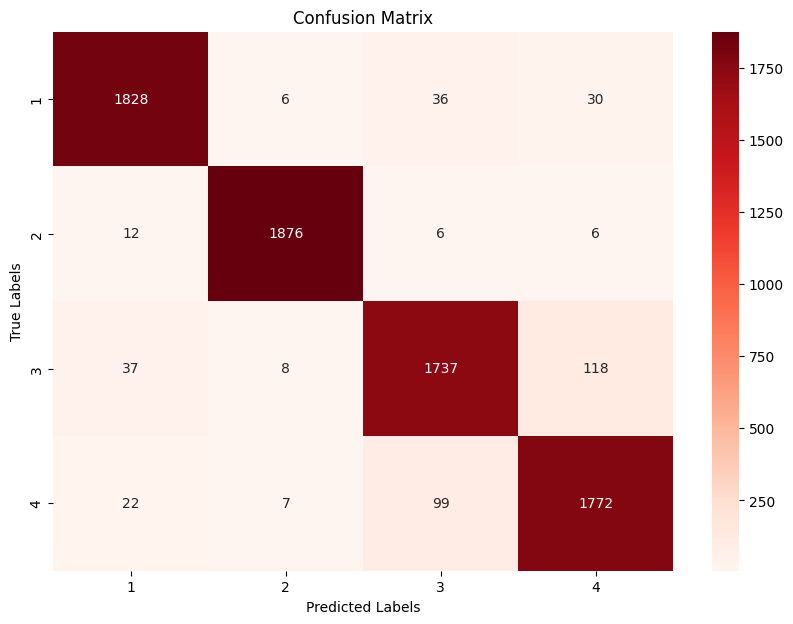

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_true, y_pred_classes)
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
cr = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(cr)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1900
           1       0.99      0.99      0.99      1900
           2       0.92      0.91      0.92      1900
           3       0.92      0.93      0.93      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600



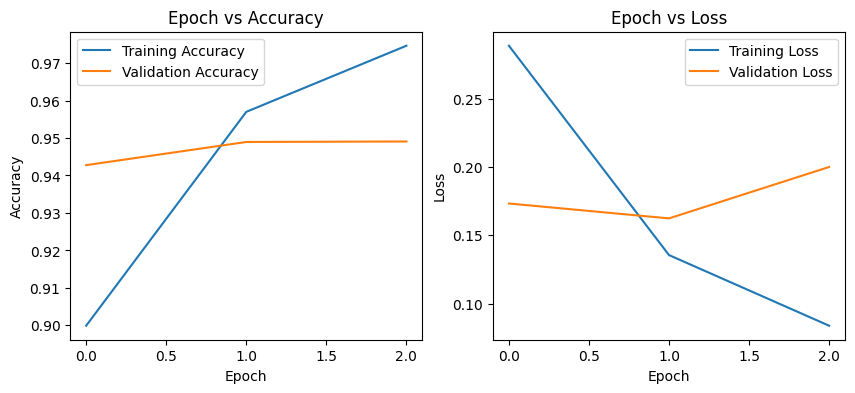

In [ ]:
# Plotting training & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
import random
import tensorflow as tf

# Sample 30 random descriptions from the test set
random_indices = random.sample(range(df_test.shape[0]), 30)
sample_test = df_test.iloc[random_indices]

# Predict on these samples using the text field
sample_test_pred_logits = model.predict(sample_test['text'])
sample_test_pred = tf.argmax(sample_test_pred_logits, axis=1)

# Extract the true labels
y_test_sample = le.transform(sample_test['Class Index'])
y_test_sample_cat = tf.keras.utils.to_categorical(y_test_sample, num_classes=4)
sample_test_true_labels = tf.argmax(y_test_sample_cat, axis=1)

# Convert predictions and true labels to category names
predictions = le.inverse_transform(sample_test_pred.numpy())
true_labels = le.inverse_transform(sample_test_true_labels.numpy())

# Print the comparison
for i, text in enumerate(sample_test['text']):
    print(f"Text: {text[:200]}...")  # Print the first 200 characters of the text
    print(f"Predicted Category: {predictions[i]}")
    print(f"True Category: {true_labels[i]}\n")


1/1 [==============================] - 4s 4s/step
Text: Japan steps up efforts for Iraq hostage release. Japan has made last-ditch efforts to secure the release of a Japanese hostage facing execution in Iraq. A Japanese government official says efforts are...
Predicted Category: 1
True Category: 1

Text: Google stock falls as share lockups expire. SAN FRANCISCO, - Shares of Google Inc. fell as much as 6.5 percent Tuesday, as selling restrictions were lifted on 39 million shares held by employees and e...
Predicted Category: 3
True Category: 3

Text: Jags Cut Compton, Maddox (AP). AP - Veteran offensive lineman Mike Compton and rookie defensive tackle Anthony Maddox were among the 12 players cut by the Jacksonville Jaguars on Sunday....
Predicted Category: 2
True Category: 2

Text: Pota #39;s dead, terror teeth remain. NEW DELHI: The ordinances to repeal the stringent anti-terror law, Pota, and amend an existing law to provide teeth to it to tackle terror received Presidential a...
Pred

In [ ]:
import tensorflow as tf

# Predict on the entire test dataset
test_pred_logits = model.predict(df_test['text'])
test_pred = tf.argmax(test_pred_logits, axis=1)

# Extract the true labels for the test dataset
y_test_all = le.transform(df_test['Class Index'])
y_test_all_cat = tf.keras.utils.to_categorical(y_test_all, num_classes=4)
test_true_labels = tf.argmax(y_test_all_cat, axis=1)

# Convert predictions and true labels to category names
predictions = le.inverse_transform(test_pred.numpy())
true_labels = le.inverse_transform(test_true_labels.numpy())

# Count correct and wrong predictions
correct_count = np.sum(test_pred == test_true_labels)
wrong_count = len(df_test) - correct_count

# Print the number of correct and incorrect predictions
print(f"Number of correct predictions: {correct_count}")
print(f"Number of incorrect predictions: {wrong_count}")



238/238 [==============================] - 982s 4s/step
Number of correct predictions: 7213
Number of incorrect predictions: 387
Text: Fears for T N pension after talks. Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul....
Predicted Category: 3
True Category: 3

Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com). SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a c...
Predicted Category: 4
True Category: 4

Text: Ky. Company Wins Grant to Study Peptides (AP). AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are ...
Predicted Category: 4
True Category: 4

Text: Prediction Unit Helps Forecast Wildfires (AP). AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and end